In [1]:
from keras.datasets import fashion_mnist
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D 
from keras.layers import UpSampling2D, Dropout, Activation, Flatten 
from keras.layers import LeakyReLU, LSTM, Conv1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras
from keras.applications import VGG16
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Using TensorFlow backend.


## 1. Autoencoder

In [44]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print('Train:', x_train.shape, y_train.shape)
print('Test:', x_test.shape, y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


In [45]:
#reshape data from 6,000 x 28 x 28 to single image dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [46]:
input_img = Input(shape=(28, 28, 1))  

#compress image for encoding:
x = Conv2D(16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, kernel_size =  (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, kernel_size = (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

#image is decoded as 28 x 28 x 1 matrix
decoded = Conv2D(1, kernel_size = (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#we use sigmoid activation and binary cross-entropy loss because pixels have 
#values between 0 and 1

In [47]:
autoencoder.fit(x_train, x_train,
                epochs = 10,
                batch_size = 128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 39s 649us/step - loss: -1144.1763 - val_loss: -1154.3859
Epoch 2/10
60000/60000 [==============================] - 39s 646us/step - loss: -1151.7403 - val_loss: -1155.2508
Epoch 3/10
60000/60000 [==============================] - 39s 649us/step - loss: -1152.1618 - val_loss: -1155.6225
Epoch 4/10
60000/60000 [==============================] - 39s 654us/step - loss: -1152.3477 - val_loss: -1155.3803
Epoch 5/10
60000/60000 [==============================] - 39s 655us/step - loss: -1152.4786 - val_loss: -1155.8162
Epoch 6/10
60000/60000 [==============================] - 40s 660us/step - loss: -1152.6088 - val_loss: -1155.9511
Epoch 7/10
60000/60000 [==============================] - 40s 660us/step - loss: -1152.6981 - val_loss: -1156.0607
Epoch 8/10
60000/60000 [==============================] - 40s 662us/step - loss: -1152.7499 - val_loss: -1156.0521
Epoch 9/10
60000/60000 [======

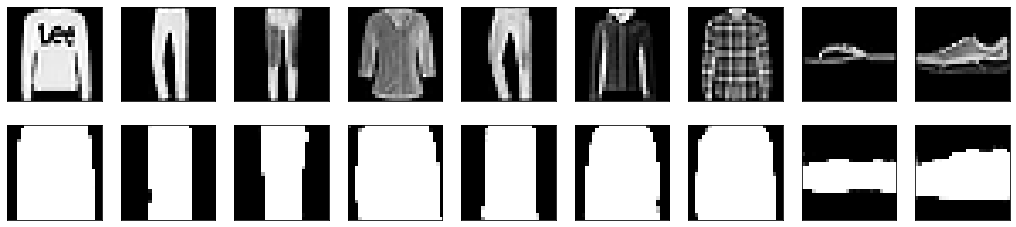

In [48]:
# Reconstructed images
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # autoencoder
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Image Classification


### 2.1 Deep CNN

Relu is chosen.

Kernal size: 3*3.

Strides: 1*1 

Pool size: 2*2.

Padding: valid padding as it will keep the most important information in the center and choose to give away other on the edge.

Network depth: 4 layers.

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
model = Sequential()
model.add(Conv2D(32,kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(32,kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten()) #flatten in order to run ANN
model.add(Dense(128, activation = 'relu')) #using 128 parameters
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax'))#output 10 results to classify 10 classes

model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [43]:
history_dCNN = model.fit(x_train, y_train, 
          epochs=5, 
          batch_size=32,
          validation_data = (x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 66s 1ms/step - loss: 0.5442 - accuracy: 0.7999 - val_loss: 0.3573 - val_accuracy: 0.8703
Epoch 2/5
60000/60000 [==============================] - 64s 1ms/step - loss: 0.3380 - accuracy: 0.8767 - val_loss: 0.2820 - val_accuracy: 0.8998
Epoch 3/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.2948 - accuracy: 0.8936 - val_loss: 0.2707 - val_accuracy: 0.9024
Epoch 4/5
60000/60000 [==============================] - 64s 1ms/step - loss: 0.2712 - accuracy: 0.9033 - val_loss: 0.2627 - val_accuracy: 0.9048
Epoch 5/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.2565 - accuracy: 0.9072 - val_loss: 0.2413 - val_accuracy: 0.9106


In [22]:
print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

10000/10000 [==============================] - 2s 225us/step
[0.245577130651474, 0.9099000096321106]
60000/60000 [==============================] - 13s 220us/step
[0.2024028450489044, 0.9270166754722595]


### 2.2 Transfer Learning

In [24]:
from keras.applications import VGG16
import skimage
from skimage.transform import resize
from tqdm import tqdm
from keras.models import Sequential

from keras import backend as K
from keras.layers import Lambda, Input
from keras.models import Model
import cv2

In [25]:
x_train1 = np.asarray([cv2.resize(i, (32,32)) for i in x_train])
x_test1 = np.asarray([cv2.resize(i, (32,32)) for i in x_test])

x_train1 = x_train1.reshape(x_train1.shape[0], 32, 32,1)
x_test1 = x_test1.reshape(x_test1.shape[0], 32, 32, 1)

x_train1 = np.asarray([np.squeeze(np.stack((i, )*3, axis = -1)) for i in x_train1])
x_test1 = np.asarray([np.squeeze(np.stack((i, )*3, axis = -1)) for i in x_test1])

In [26]:
conv_base = VGG16(weights = "imagenet", include_top=False, input_shape = (32,32,3))

58892288/58889256 [==============================] - 7s 0us/step


In [34]:
model_22 = Sequential()
model_22.add(conv_base)
model_22.add(Flatten())
model_22.add(Dense(64, activation="relu"))
model_22.add(Dense(10, activation="softmax"))

In [35]:
model_22.trainable_weights

[<tf.Variable 'dense_9/kernel:0' shape=(512, 64) dtype=float32>,
 <tf.Variable 'dense_9/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_10/kernel:0' shape=(64, 10) dtype=float32>,
 <tf.Variable 'dense_10/bias:0' shape=(10,) dtype=float32>]

In [36]:
conv_base.trainable = False

In [37]:
model_22.trainable_weights

[<tf.Variable 'dense_9/kernel:0' shape=(512, 64) dtype=float32>,
 <tf.Variable 'dense_9/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_10/kernel:0' shape=(64, 10) dtype=float32>,
 <tf.Variable 'dense_10/bias:0' shape=(10,) dtype=float32>]

In [38]:
model_22.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [39]:
trained_22 = model_22.fit(x_train1,y_train, 
                    epochs=10, 
                    batch_size=64,
                    verbose = 1,
                    validation_data = (x_test1, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 286s 5ms/step - loss: 0.6136 - accuracy: 0.7901 - val_loss: 0.4781 - val_accuracy: 0.8286
Epoch 2/10
60000/60000 [==============================] - 288s 5ms/step - loss: 0.4356 - accuracy: 0.8424 - val_loss: 0.4444 - val_accuracy: 0.8396
Epoch 3/10
60000/60000 [==============================] - 285s 5ms/step - loss: 0.4004 - accuracy: 0.8535 - val_loss: 0.4163 - val_accuracy: 0.8499
Epoch 4/10
60000/60000 [==============================] - 286s 5ms/step - loss: 0.3811 - accuracy: 0.8604 - val_loss: 0.4066 - val_accuracy: 0.8544
Epoch 5/10
60000/60000 [==============================] - 285s 5ms/step - loss: 0.3650 - accuracy: 0.8654 - val_loss: 0.3981 - val_accuracy: 0.8569
Epoch 6/10
60000/60000 [==============================] - 286s 5ms/step - loss: 0.3528 - accuracy: 0.8698 - val_loss: 0.3880 - val_accuracy: 0.8600
Epoch 7/10
60000/60000 [==============================] - 284s

In [40]:
print(model_22.evaluate(x_test1, y_test))
print(model_22.evaluate(x_train1, y_train))

10000/10000 [==============================] - 39s 4ms/step
[0.3752091684103012, 0.8691999912261963]
60000/60000 [==============================] - 233s 4ms/step
[0.3030406946659088, 0.8899499773979187]


## 3. Text Classification

In [53]:
import pandas as pd
import nltk
import collections
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Dropout, Activation, Flatten, GlobalMaxPooling1D, LSTM
from keras.callbacks import TensorBoard
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.utils import class_weight
from keras.layers import LSTM, Conv1D, GlobalMaxPooling1D
import regex as re
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing import sequence

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evelyn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/evelyn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/evelyn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
tweets = pd.read_csv('tweets_with_labels.csv', sep = '\t')

# Clean
stopWords = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_tweets(tweet):
    tweet = re.sub("@mention", "",tweet)
    tweet = re.sub("{link}", "",tweet)
    tweet = re.sub("[^A-Za-z]"," ",tweet)
    tweet = re.sub(r'\bRT\b', '', tweet)
    tweet = re.sub("\s+"," ",tweet)
    tokens = word_tokenize(tweet)
    words = [word for word in tokens if word not in stopWords]
    words = [stemmer.stem(w).strip("'") for w in words]
    words = [lemmatizer.lemmatize(w, pos="a") for w in words]
    words = [word for word in words if len(word)!=1]
    final_tweet = ' '.join(words)
    return final_tweet

new_tweet = [preprocess_tweets(x) for x in list(tweets.tweet)]
tweets['new_tweets'] = new_tweet

In [62]:
token = [word_tokenize(x) for x in list(tweets.new_tweets)]

# Clean
remove_lst=[]
for w in token:
    remove_lst.append(len(w))
bad_idx = [n for n,x in enumerate(remove_lst) if x == 0]
tweets_updated = tweets.drop(bad_idx)

In [63]:
X = [word_tokenize(x) for x in list(tweets_updated['new_tweets'])]

# label y for any k1 to k15 not equal to 0
label = tweets_updated.loc[:,'k1':'k15']
label[tweets_updated != 0] = 1
Y = label.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=13)

In [64]:
print('X_train shape: ', len(X_train))
print('X_test shape: ', len(X_test))
print('y_train shape: ', Y_train.shape)
print('y_test shape: ', Y_test.shape)

X_train shape:  54551
X_test shape:  23379
y_train shape:  (54551, 15)
y_test shape:  (23379, 15)


In [65]:
# padding token sequense to max length of 40
X_train_padded = sequence.pad_sequences(X_train, maxlen=40, padding="post", truncating="post", value='_pad_',dtype=object)
X_test_padded = sequence.pad_sequences(X_test, maxlen=40, padding="post", truncating="post", value='_pad_',dtype=object)

train_corpus = list(tweets_updated.new_tweets)
train_cor_tk = [word_tokenize(x) for x in train_corpus]
corpus_padded = sequence.pad_sequences(train_cor_tk, maxlen=40,padding="post", truncating="post", value='_pad_',dtype=object)

corpus_padded = corpus_padded.tolist()
X_train_padded = X_train_padded.tolist()
X_test_padded = X_test_padded.tolist()

In [66]:
# train word2vec and vectorizing training set and test set 
w2v_model = Word2Vec(corpus_padded, min_count=1, size = 20, workers=1, window=3)

# vector with size train/test, maxlen = 40 
X_train_vec = np.empty([len(X_train), 40, 20])
X_test_vec = np.empty([len(X_test), 40, 20])

idx_train = 0
for w in X_train_padded:
    X_train_vec[idx_train, :, :] = w2v_model[w]
    idx_train += 1

idx_test = 0
for w in X_test_padded:
    X_test_vec[idx_test,:,:] = w2v_model[w]
    idx_test += 1

print('X_train_vec shape: ', X_train_vec.shape)
print('X_test_vec shape: ', X_test_vec.shape)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


X_train_vec shape:  (54551, 40, 20)
X_test_vec shape:  (23379, 40, 20)


In [67]:
# Build LSTM model
model_rnn = Sequential()
model_rnn.add(LSTM(128, input_shape = (40, 20)))
model_rnn.add(Dense(128, activation = 'relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(64, activation = 'relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(15, activation ='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history = model_rnn.fit(X_train_vec, Y_train,
                        epochs=10, batch_size=500,
                        validation_data=(X_test_vec, Y_test))

Train on 54551 samples, validate on 23379 samples
Epoch 1/10
54551/54551 [==============================] - 20s 373us/step - loss: 0.3692 - accuracy: 0.8517 - val_loss: 0.3217 - val_accuracy: 0.8748
Epoch 2/10
54551/54551 [==============================] - 20s 362us/step - loss: 0.3315 - accuracy: 0.8725 - val_loss: 0.3210 - val_accuracy: 0.8748
Epoch 3/10
54551/54551 [==============================] - 19s 357us/step - loss: 0.3282 - accuracy: 0.8732 - val_loss: 0.3209 - val_accuracy: 0.8748
Epoch 4/10
54551/54551 [==============================] - 19s 354us/step - loss: 0.3262 - accuracy: 0.8738 - val_loss: 0.3208 - val_accuracy: 0.8748
Epoch 5/10
54551/54551 [==============================] - 19s 352us/step - loss: 0.3254 - accuracy: 0.8743 - val_loss: 0.3213 - val_accuracy: 0.8748
Epoch 6/10
54551/54551 [==============================] - 19s 349us/step - loss: 0.3246 - accuracy: 0.8744 - val_loss: 0.3211 - val_accuracy: 0.8748
Epoch 7/10
54551/54551 [==============================] 

In [70]:
#from sklearn import metrics

# Evaluate
score = model_31.evaluate(X_test_vec, Y_test, batch_size=64, verbose = 0)

print('Train loss: ', history.history['loss'][9]) 
print('Train accuracy: ', history.history['accuracy'][9])

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Train loss:  0.20556983022713332
Train accuracy:  0.9236665
Test loss:  0.684796143406201
Test accuracy:  0.5469837784767151


### 3.2 CNN

In [72]:
model_cnn = Sequential()
model_cnn.add(Conv1D(128, 3, activation='relu', padding = 'valid', strides=1, input_shape=(40,20)))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64))
model_cnn.add(Dropout(0.2))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(15, activation ='sigmoid'))

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train_vec, Y_train, epochs=10, batch_size=128,
                        validation_data=(X_test_vec, Y_test))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 54551 samples, validate on 23379 samples
Epoch 1/10
54551/54551 [==============================] - 2s 43us/step - loss: 0.2338 - accuracy: 0.9144 - val_loss: 0.1710 - val_accuracy: 0.9385
Epoch 2/10
54551/54551 [==============================] - 2s 36us/step - loss: 0.1783 - accuracy: 0.9374 - val_loss: 0.1603 - val_accuracy: 0.9428
Epoch 3/10
54551/54551 [==============================] - 2s 36us/step - loss: 0.1689 - accuracy: 0.9410 - val_loss: 0.1565 - val_accuracy: 0.9441
Epoch 4/10
54551/54551 [==============================] - 2s 35us/step - loss: 0.1641 - accuracy: 0.9424 - val_loss: 0.1535 - val_accuracy: 0.9453
Epoch 5/10
54551/54551 [==============================] - 2s 35us/step - loss: 0.1615 - accuracy: 0.9433 - val_loss: 0.1514 - val_accuracy: 0.9456
Epoch 6/10
54551/54551 [==============================] - 2s 36us/step - loss: 0.1591 - accuracy: 0.9438 - val_loss: 0.1509 - val_accurac

In [73]:
# evaluate the model
score_32 = model_cnn.evaluate(X_test_vec, Y_test, batch_size=64, verbose = 0)

In [76]:
from sklearn import metrics

print('Train loss: ', history_cnn.history['loss'][9]) 
print('Train accuracy: ', history_cnn.history['accuracy'][9])

print('Test loss: ', score_32[0])
print('Test accuracy: ', score_32[1])

Train loss:  0.15320684212098426
Train accuracy:  0.9454591
Test loss:  0.14777043804770443
Test accuracy:  0.9469500184059143


### 3.3

Text(0.5, 1.0, 'Text Classification - RNN vs CNN Accuracy Comparison')

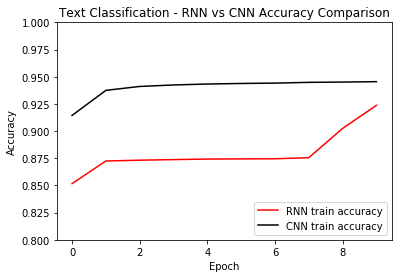

In [78]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='RNN train accuracy', color = 'r')
plt.plot(history_cnn.history['accuracy'], label = 'CNN train accuracy', color = 'k')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Text Classification - RNN vs CNN Accuracy Comparison')

Text(0.5, 1.0, 'Text Classification - RNN vs CNN Loss Comparison')

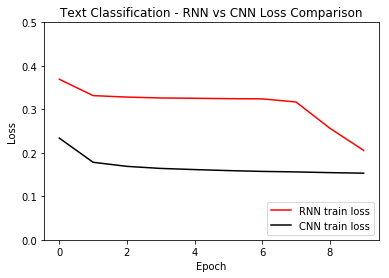

In [79]:
plt.plot(history.history['loss'], label='RNN train loss', color = 'r')
plt.plot(history_cnn.history['loss'], label = 'CNN train loss', color = 'k')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.5])
plt.legend(loc='lower right')
plt.title('Text Classification - RNN vs CNN Loss Comparison')

In first accuracy plot, CNN has average higher accuracy than RNN.

And in the second loss plot, CNN has less train loss than RNN.

So overall CNN performs better than RNN model.